Generate the 3:2:1 Crack spread and plot it

3807


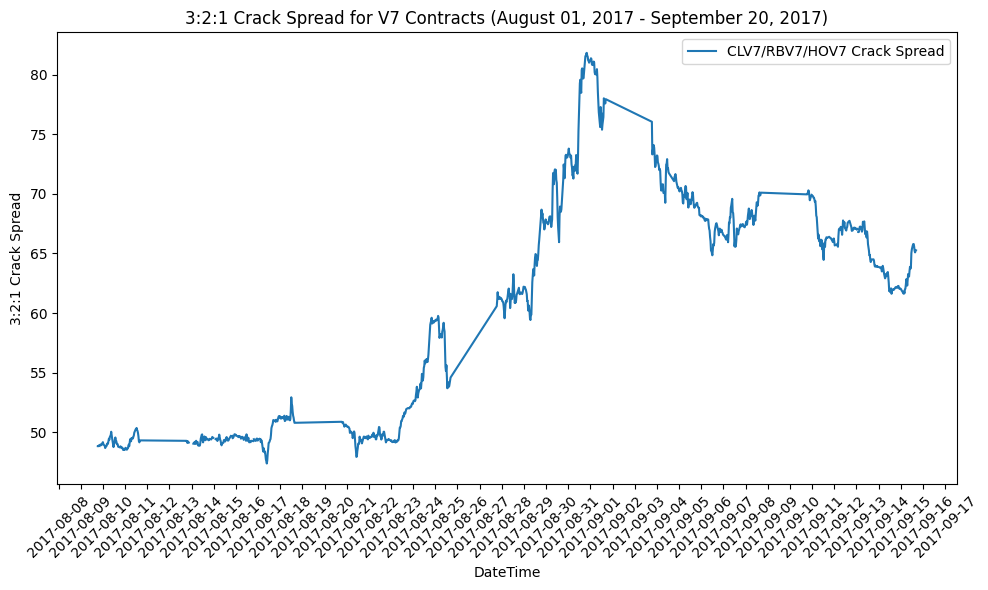

In [2]:
# This code generates the 3:2:1 crack spread, and plots it in a graph for hurricane harvey in August-September 2017. 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Load data
file_path = 'Intraday_Data/AL092017.csv'
data = pd.read_csv(file_path)

# Convert date and time to a datetime format
data['datetime'] = pd.to_datetime(data['date']) + pd.to_timedelta(data['time'], unit='min')

# Convert HO and RB prices to per barrel
data.loc[data['sym'].str.contains('HO') | data['sym'].str.contains('RB'), ['bid', 'ask', 'prc']] *= 42

# Filter data for the desired date range and specific contracts
start_date = datetime(2017, 8, 1)
end_date = datetime(2017, 9, 20)
filtered_data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]
# filtered_data = filtered_data[filtered_data['sym'].isin(['CLU7', 'RBU7', 'HOU7', 'CLV7', 'RBV7', 'HOV7'])]
filtered_data = filtered_data[filtered_data['sym'].isin([ 'CLV7', 'RBV7', 'HOV7'])]

print(len(filtered_data))


# Pivot the data for easier calculation
pivoted_data = filtered_data.pivot_table(index='datetime', columns='sym', values='prc')

# Calculate the 3:2:1 crack spreads
# pivoted_data['crack_spread_U7'] = -1 * (3 * pivoted_data['CLU7'] - 2 * pivoted_data['RBU7'] - pivoted_data['HOU7'])
pivoted_data['crack_spread_V7'] = -1* ( 3 * pivoted_data['CLV7'] - 2 * pivoted_data['RBV7'] - pivoted_data['HOV7'])

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(pivoted_data.index, pivoted_data['crack_spread_U7'], label='CLU7/RBU7/HOU7 Crack Spread')
plt.plot(pivoted_data.index, pivoted_data['crack_spread_V7'], label='CLV7/RBV7/HOV7 Crack Spread')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)
plt.xlabel('DateTime')
plt.ylabel('3:2:1 Crack Spread')
plt.title(f'3:2:1 Crack Spread for V7 Contracts ({start_date.strftime("%B %d, %Y")} - {end_date.strftime("%B %d, %Y")})')
plt.legend()
plt.tight_layout()
plt.show()



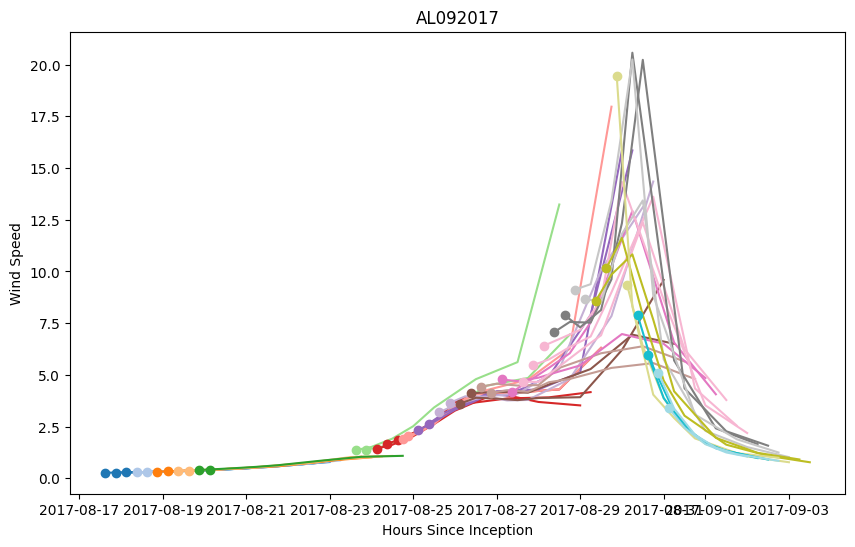

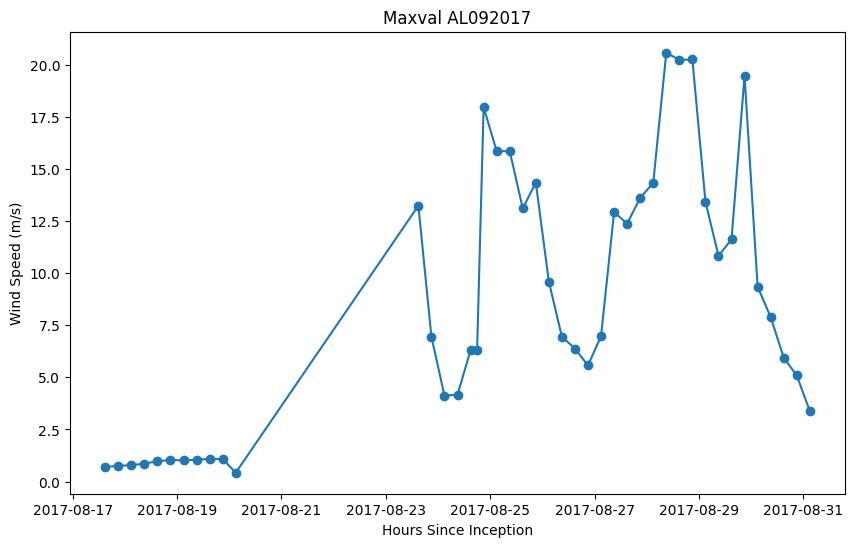

In [3]:
import matplotlib.pyplot as plt
import pickle
from dateutil import parser
import re
from matplotlib import cm
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime, timedelta
    
# function to define the hurricane score
def wind_speed(distance, v_m, r_m):

    b = 2
    x = 0
    s = 0.5
    x = ((r_m/distance)**b)*np.exp(1-(r_m/distance)**b)

    return v_m*x**s

# function to calculate distance using lat, lon (distance in km)
def distance(loc1, loc2):
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = radians(loc1[0])
    lon1 = radians(loc1[1])
    lat2 = radians(loc2[0])
    lon2 = radians(loc2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

# define set of functions to predict Rmax8
def calc_f(lat):
    return 2*.00007292*sin(radians(lat))

def calc_mratio(v_max, r_175, lat):
    return 0.699 * np.exp(-0.00618*(v_max - 17.5)-0.00210*(v_max - 17.5)*(1/2*calc_f(lat)*r_175))

def calc_m175(r_175, lat):
    return r_175 * 17.5 + 1/2 * calc_f(lat)*r_175**2

def calc_rmax(v_max, r_175, lat):
    return v_max/(calc_f(lat))*(sqrt(1+2*calc_f(lat)*(calc_m175(r_175, lat)*calc_mratio(v_max, r_175, lat))/(v_max**2))-1)

# define list of storms to plot wind speed

storm_codes = ['AL092017']
month = 8

for storm in storm_codes:
    year = int(storm[-4:])

    with open(f"Data/{year}data.pkl", 'rb') as f:
        x = pickle.load(f)

    galveston = ([29.3013, -94.7977])

    # Initialize inception time (storm inception time)
    inception_time_str = x[storm]['1']['INIT']['Time (UTC)']
    inception_day = int(inception_time_str[:2])
    inception_month = month
    inception_year = year
    inception_hour = 0 # updated later
    inception_time = datetime(inception_year, inception_month, inception_day, inception_hour)

    # set up the figure for each storm
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title(f"{storm}")
    plt.xlabel("Hours Since Inception")
    plt.ylabel("Wind Speed")

    day_count = 0
    prev28 = 0
    prev29 = 0
    prev30 = 0
    prev31 = 0
    base_day = list(inception_time_str)[0:2]
    base_day = [int(base_day[0]), int(base_day[1])]
    # print("BD1:", base_day)
    max_harr = []
    t_release = []

    for i, key in enumerate(x[storm].keys()):
        times = []
        wind_speeds = []
        lat_arr = []
        lon_arr = []
        hscore_arr = []
        peak_fspeed = 0 # to find the max speed in a given forecast

        for j, key2 in enumerate(x[storm][key].keys()):
        
            # print(key, key2) # for debugging

            if (x[storm][key][key2]['Dissipated?'] != True):

                lat = x[storm][key][key2]['Latitude']
                lon = x[storm][key][key2]['Longitude']
                ws_temp = x[storm][key][key2]['Wind Speed (KT)']   
                
                time_string = list(x[storm][key][key2]['Time (UTC)']) # need to include timing later

                current_day = [int(time_string[0]), int(time_string[1])]
                add31 = 0
                if ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1])) < 0:
                    if prev_day == [3,1]:
                        prev31 = 1
                    elif prev_day == [3,0]:
                        prev30 = 1
                    elif prev_day == [2,9]:
                        prev29 = 1
                    elif prev_day == [2,8]:
                        prev28 = 1
                    
                    adds = prev28 * 28 + prev29 * 29 + prev30 * 30 + prev31 * 31
                    day_hrs = ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1]) + adds)* 24
                    hour = int(time_string[3]) * 10 + int(time_string[4]) + day_hrs
                    # print(hour)
                    
                    current_datetime = inception_time + timedelta(hours=hour)
                    times.append(current_datetime)
                else:
                    day_hrs = ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1]))* 24
                    hour = int(time_string[3]) * 10 + int(time_string[4]) + day_hrs
                    # print(hour)

                    # Extract time and convert to datetime
                    current_datetime = inception_time + timedelta(hours=hour)
                    times.append(current_datetime)
            
                wind_speeds.append(int(ws_temp))

                if (lat[-1] == "N"):
                    lat_arr.append(float(lat[0:-1]))
                elif (lat[-1] == "S"):
                    lat_arr.append(-float(lat[0:-1]))
                if (lon[-1] == "E"):
                    lon_arr.append(float(lon[0:-1]))
                elif (lon[-1] == "W"):
                    lon_arr.append(-float(lon[0:-1]))
                city = galveston
                dist = distance(city, np.array([lat_arr[-1], lon_arr[-1]]))
                windspeed_ms = int(ws_temp) * 0.5144 # change from knots to m/s
                hscore_arr.append(wind_speed(dist, windspeed_ms, calc_rmax(windspeed_ms, 60, lat_arr[-1]))) # calculate

                if (hscore_arr[-1] > peak_fspeed):
                    peak_fspeed = hscore_arr[-1]

                prev_day = current_day
        
        max_harr.append(peak_fspeed)
        t_release.append(times[0])

        colormap = cm.tab20
        color = colormap(i / len(x[storm]))

        # plotting the forecasts
        ax.plot(times[0], hscore_arr[0], marker = "o", color = color)
        ax.plot(times, hscore_arr, color=color, label = key)
        # ax.legend()

    plt.show()

    # max hscore plot per discussion
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    plt.title(f"Maxval {storm}")
    plt.xlabel("Hours Since Inception")
    plt.ylabel("Wind Speed (m/s)")
    ax2.plot(t_release, max_harr, marker = "o")
    plt.show()


    




In [4]:
import pandas as pd

# Assuming 't_release' contains the timestamps and 'max_harr' contains the wind speeds
wind_speed_data = pd.DataFrame({
    'datetime': pd.Series(t_release),
    'max_harr': max_harr
})

# Filter out rows where max_harr is below 4
filtered_wind_speed_data = wind_speed_data[wind_speed_data['max_harr'] >= 4]


# Convert the timestamps in filtered_wind_speed_data and pivoted_data to a common format (seconds since the Unix epoch)
time_format = lambda x: (x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
filtered_wind_speed_data['datetime'] = filtered_wind_speed_data['datetime'].apply(time_format)

# Prepare the crack spread data
pivoted_data_reset = pivoted_data.reset_index()
pivoted_data_seconds = pd.DataFrame({
    'datetime': pivoted_data_reset['datetime'].map(time_format),
    'crack_spread_V7': pivoted_data_reset['crack_spread_V7']
})

# Merge based on the exact timestamp match
merged_data = pd.merge(filtered_wind_speed_data,
                       pivoted_data_seconds,
                       on='datetime',
                       how='inner')

# The result is a DataFrame with aligned wind speed and crack spread data
aligned_wind_speed = merged_data['max_harr']
aligned_crack_spread = merged_data['crack_spread_V7']


/var/folders/56/glwsl01j2jv_87_l49k_p9tw0000gn/T/ipykernel_17303/2323523883.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_wind_speed_data['datetime'] = filtered_wind_speed_data['datetime'].apply(time_format)


Ordinary OLS

OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:        crack_spread_V7   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.050
Method:                 Least Squares   F-statistic:                 0.0007723
Date:                Thu, 28 Mar 2024   Prob (F-statistic):              0.978
Time:                        23:52:39   Log-Likelihood:                -70.747
No. Observations:                  22   AIC:                             145.5
Df Residuals:                      20   BIC:                             147.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.0292      3

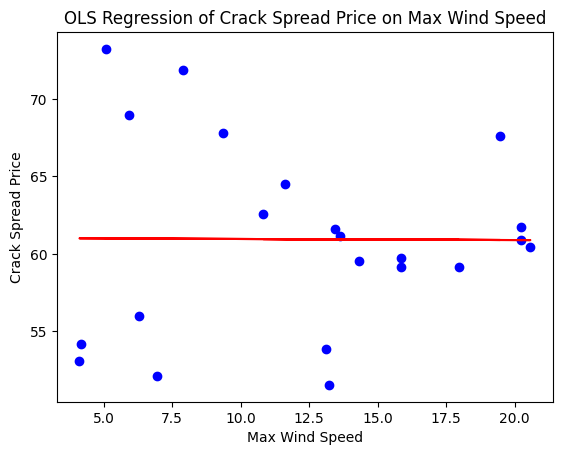

In [5]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Extracting the aligned wind speed data
aligned_max_harr = merged_data['max_harr'].values


# Reshape aligned wind speed data for regression analysis
X = aligned_max_harr.reshape(-1, 1)
y = aligned_crack_spread

# Adding a constant to the model for the intercept
X_with_constant = sm.add_constant(X)

# Building the OLS model
ols_model = sm.OLS(y, X_with_constant)

# Fitting the OLS model
ols_results = ols_model.fit()

# Printing the summary statistics
print("OLS Regression Results:")
print(ols_results.summary())

# Plotting the results
plt.scatter(X, y, color='blue')
plt.plot(X, ols_results.predict(X_with_constant), color='red')
plt.xlabel('Max Wind Speed')
plt.ylabel('Crack Spread Price')
plt.title('OLS Regression of Crack Spread Price on Max Wind Speed')
plt.show()



Results for different lags:
Lag: 0 minutes, R²: 0.18082721861355078, Coefficient: 0.44381493889952045, P-value: 0.004474627652779164
Lag: 30 minutes, R²: 0.18608324219109662, Coefficient: 0.4485033225039217, P-value: 0.003875522525692939
Lag: 60 minutes, R²: 0.19044339988580028, Coefficient: 0.45138371213521966, P-value: 0.003438394377256
Lag: 90 minutes, R²: 0.18683950546139483, Coefficient: 0.44628646134185745, P-value: 0.0037960138813920388
Lag: 120 minutes, R²: 0.18553157943038978, Coefficient: 0.4431668439570867, P-value: 0.003934539838052608
Lag: 150 minutes, R²: 0.18861240333981144, Coefficient: 0.4443750838766664, P-value: 0.0036157886864694607
Lag: 180 minutes, R²: 0.17342764289879942, Coefficient: 0.43649614433539213, P-value: 0.00547321792524735
Lag: 210 minutes, R²: 0.17499264212102772, Coefficient: 0.43802659134570515, P-value: 0.00524538410453537
Lag: 240 minutes, R²: 0.162921801607678, Coefficient: 0.4297896665559944, P-value: 0.00727292832760684
Lag: 270 minutes, R²: 0.

/var/folders/56/glwsl01j2jv_87_l49k_p9tw0000gn/T/ipykernel_10158/1969385762.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Coefficient': ols_results.params[1],
/var/folders/56/glwsl01j2jv_87_l49k_p9tw0000gn/T/ipykernel_10158/1969385762.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P_value': ols_results.pvalues[1]
/var/folders/56/glwsl01j2jv_87_l49k_p9tw0000gn/T/ipykernel_10158/1969385762.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position,

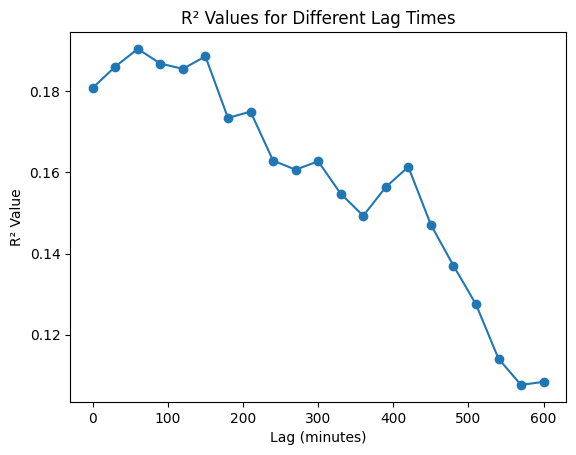

In [20]:
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Your initial data: max_harr and t_release
# max_harr = [...]
# t_release = [...]

# Define the range of lags to test
lag_range = range(0, 601, 30)  # From 30 to 300 minutes, in steps of 30 minutes

# Dictionary to store results for each lag
results = {}

# Loop over the specified range of lags
for lag_minutes in lag_range:
    # Steps 1 to 5 from your code with adjusted lag
    wind_speed_data = pd.DataFrame({
        'datetime': pd.Series(t_release),
        'max_harr': max_harr
    }).query('max_harr >= 0')

    wind_speed_data['datetime_lagged'] = wind_speed_data['datetime'] + pd.to_timedelta(lag_minutes, unit='min')
    wind_speed_seconds = wind_speed_data['datetime_lagged'].apply(lambda x: x.timestamp()).values

    pivoted_data_seconds = pivoted_data.index.map(lambda x: x.timestamp())
    tree = KDTree(pivoted_data_seconds.values.reshape(-1, 1))
    _, indices = tree.query(wind_speed_seconds.reshape(-1, 1))

    aligned_crack_spreads = pivoted_data['crack_spread_V7'].iloc[indices].values
    wind_speed_data['aligned_crack_spread'] = aligned_crack_spreads
    wind_speed_data = wind_speed_data.dropna()

    # Regression Analysis for each lag
    X = wind_speed_data['max_harr'].values.reshape(-1, 1)
    y = wind_speed_data['aligned_crack_spread']

    X_with_constant = sm.add_constant(X)
    ols_model = sm.OLS(y, X_with_constant)
    ols_results = ols_model.fit()

    # Record results
    results[lag_minutes] = {
        'R_squared': ols_results.rsquared,
        'Coefficient': ols_results.params[1],
        'P_value': ols_results.pvalues[1]
    }

# Print the results for each lag
print("Results for different lags:")
for lag, result in results.items():
    print(f"Lag: {lag} minutes, R²: {result['R_squared']}, Coefficient: {result['Coefficient']}, P-value: {result['P_value']}")

# Optionally, plot the R² values
plt.figure()
plt.plot([lag for lag in results], [result['R_squared'] for result in results.values()], marker='o')
plt.xlabel('Lag (minutes)')
plt.ylabel('R² Value')
plt.title('R² Values for Different Lag Times')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming t_release and pivoted_data.index are already aligned as per your previous instructions
# and 'aligned_crack_spread' contains the corresponding crack spread values

# Plotting
fig, ax1 = plt.subplots()

# Setting up the first axis for crack spread prices
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Crack Spread Price', color=color)
ax1.plot(pivoted_data.index[indices], aligned_crack_spread, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Setting up the x-axis for dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Setting up the second axis for max wind speed
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Max Wind Speed (m/s)', color=color)
ax2.plot(t_release_series, max_harr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
fig.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats

# Assuming max_harr and aligned_crack_spread are your data series

# Pearson Correlation
pearson_corr, _ = scipy.stats.pearsonr(max_harr, aligned_crack_spread)
print(f'Pearson Correlation Coefficient: {pearson_corr}')

# Spearman's Rank Correlation
spearman_corr, _ = scipy.stats.spearmanr(max_harr, aligned_crack_spread)
print(f'Spearman Rank Correlation Coefficient: {spearman_corr}')

# Kendall's Tau
kendall_tau, _ = scipy.stats.kendalltau(max_harr, aligned_crack_spread)
print(f'Kendall Tau Coefficient: {kendall_tau}')


Time lag

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Create DataFrame for wind speed data
wind_speed_data = pd.DataFrame({
    't_release': t_release,
    'max_harr': max_harr
})
wind_speed_data.set_index('t_release', inplace=True)

# Align wind speed data with crack spread data
aligned_data = pivoted_data['crack_spread_V7'].to_frame().join(wind_speed_data, how='inner')

# Generate lagged wind speed data
for lag in range(1,4):
    aligned_data[f'max_harr_lag_{lag}'] = aligned_data['max_harr'].shift(lag)

# Drop rows with NaN values (due to lagging)
aligned_data.dropna(inplace=True)

# Separate dependent and independent variables
X = aligned_data[['max_harr', 'max_harr_lag_1', 'max_harr_lag_2', 'max_harr_lag_3']]
y = aligned_data['crack_spread_V7']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create a model and fit it
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


Using only t-1

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Assuming t_release, max_harr, and pivoted_data are already defined in your environment

# Create DataFrame for wind speed data
wind_speed_data = pd.DataFrame({
    't_release': t_release,
    'max_harr': max_harr
})
wind_speed_data.set_index('t_release', inplace=True)

# Align wind speed data with crack spread data
aligned_data = pivoted_data['crack_spread_V7'].to_frame().join(wind_speed_data, how='inner')

# Generate lagged wind speed data for t-1
aligned_data['max_harr_lag_3'] = aligned_data['max_harr'].shift(3)

# Drop rows with NaN values (due to lagging)
aligned_data.dropna(inplace=True)

# Separate dependent and independent variables
X = aligned_data[['max_harr_lag_3']]  # Only the t-1 lagged variable
y = aligned_data['crack_spread_V7']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create a model and fit it
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


Experimental: Delta values

In [ ]:
import pandas as pd

# Assuming you already have 'pivoted_data' and 't_release'
# Convert 't_release' to a Pandas Series of datetime objects
t_release_series = pd.Series(pd.to_datetime(t_release))

# Assuming 'max_harr' is a list or Pandas Series of maximum hurricane scores
max_harr_series = pd.Series(max_harr)

# Calculate the difference between the current and previous max wind speed
max_harr_diff = max_harr_series.diff().fillna(0)

# Define a 30-minute timedelta
time_delta = pd.Timedelta(minutes=30)

# Initialize lists to store the delta crack spread data
times = []
delta_spreads = []

# Loop through each forecast release time
for release_time in t_release_series:
    # Calculate exact times 30 minutes before and after the release time
    before_time = release_time - time_delta
    after_time = release_time + time_delta

    # Check if these exact times exist in `pivoted_data`
    if before_time in pivoted_data.index and after_time in pivoted_data.index:
        # Calculate the delta crack spread
        delta = pivoted_data.loc[after_time, 'crack_spread_V7'] - pivoted_data.loc[before_time, 'crack_spread_V7']
        times.append(release_time)
        delta_spreads.append(delta)

# Create DataFrames
delta_crack_spread_df = pd.DataFrame({'time': times, 'delta_spread': delta_spreads})
max_harr_diff_df = pd.DataFrame({'time': t_release_series, 'max_harr_diff': max_harr_diff})

# Merge the dataframes
regression_data = pd.merge(delta_crack_spread_df, max_harr_diff_df, on='time', how='inner')

# Check the merged data
print(regression_data.head())

# X variable - Difference in max hurricane scores
X = regression_data['max_harr_diff']

# Y variable - Delta crack spread
Y = regression_data['delta_spread']


In [ ]:
import statsmodels.api as sm

# Assuming X and Y are defined as per the previous discussion
# X is the maximum hurricane scores, and Y is the delta crack spreads

# Add a constant to the model (for the intercept)
X_with_constant = sm.add_constant(X)

# Create the model
model = sm.OLS(Y, X_with_constant)

# Fit the model
results = model.fit()

# Print the summary of the regression
print(results.summary())
